# Making Figure 1

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults, add_units
ps_defaults(use_tex=False, dpi=150)

In [4]:
from src.constants import ERSSTV5_PATH, NOAA_DATA_PATH, cmip6_ensemble_var
from src.plot_utils import label_subplots
from src.xr_utils import can_coords, sel, get_trend, spatial_mean

In [5]:
ts_ensemble = sel(can_coords(xr.open_mfdataset(cmip6_ensemble_var("ts") + "/*.nc")).ts, reg="pac")

warning, not changing:  member


In [6]:
ts_nino34_ensemble = spatial_mean(sel(ts_ensemble, reg="nino3.4")).compute()

In [7]:
ts_nino34_mean = ts_nino34_ensemble.mean("member").compute()

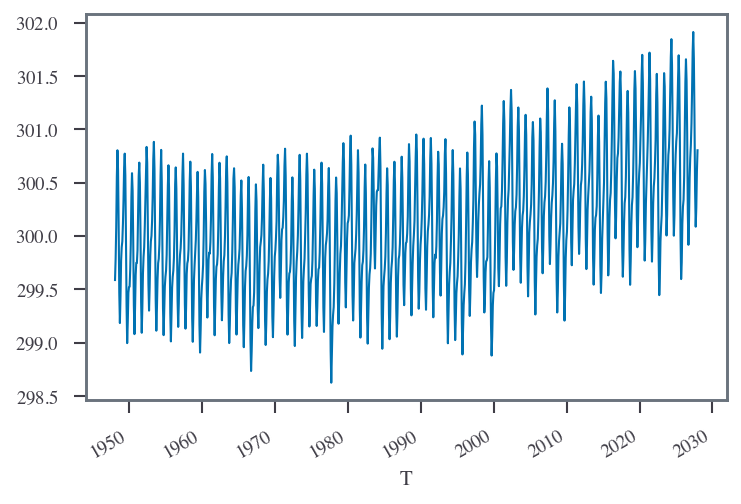

In [8]:
ts_nino34_mean.plot()

In [31]:
ts_nino34_mean_trend = get_trends(ts_nino34_mean)#.sel(T=slice("1958", "2017"))

In [32]:
ts_nino34_ensemble_trend = get_trends(ts_nino34_ensemble)

In [10]:
def get_trends(da: xr.DataArray, beginning=2007, finish=2017) -> xr.Dataset:
    da_tr_list = []
    for start, end in [(str(x - 59), str(x)) for x in range(beginning, finish+1)]:
        da_tr_list.append(
            get_trend(da.sel(T=slice(start, end)), keep_ds=True).expand_dims({"end_year": [int(end)]})
        )
    da_tr = xr.merge(da_tr_list)
    da_tr.end_year.attrs["long_name"] = "End year"
    da_tr.rise.attrs["units"] = "K"
    da_tr.rise.attrs["long_name"] = "Trend over 60 years up to end year"
    return da_tr

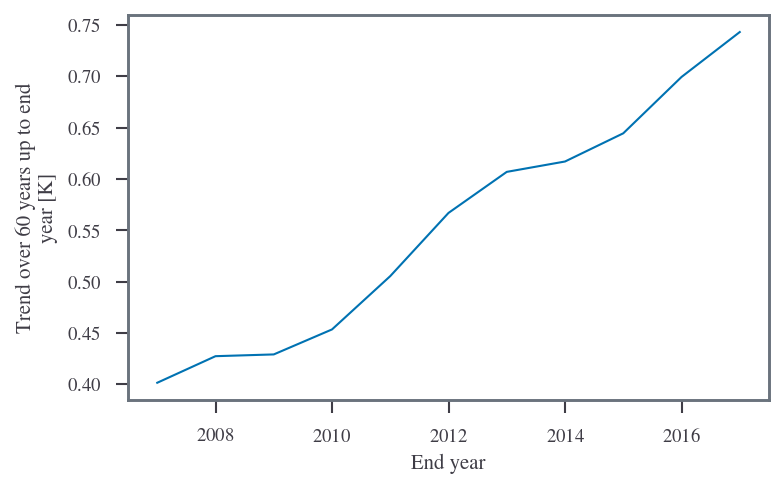

In [15]:
ts_nino34_mean_trend.rise.plot()

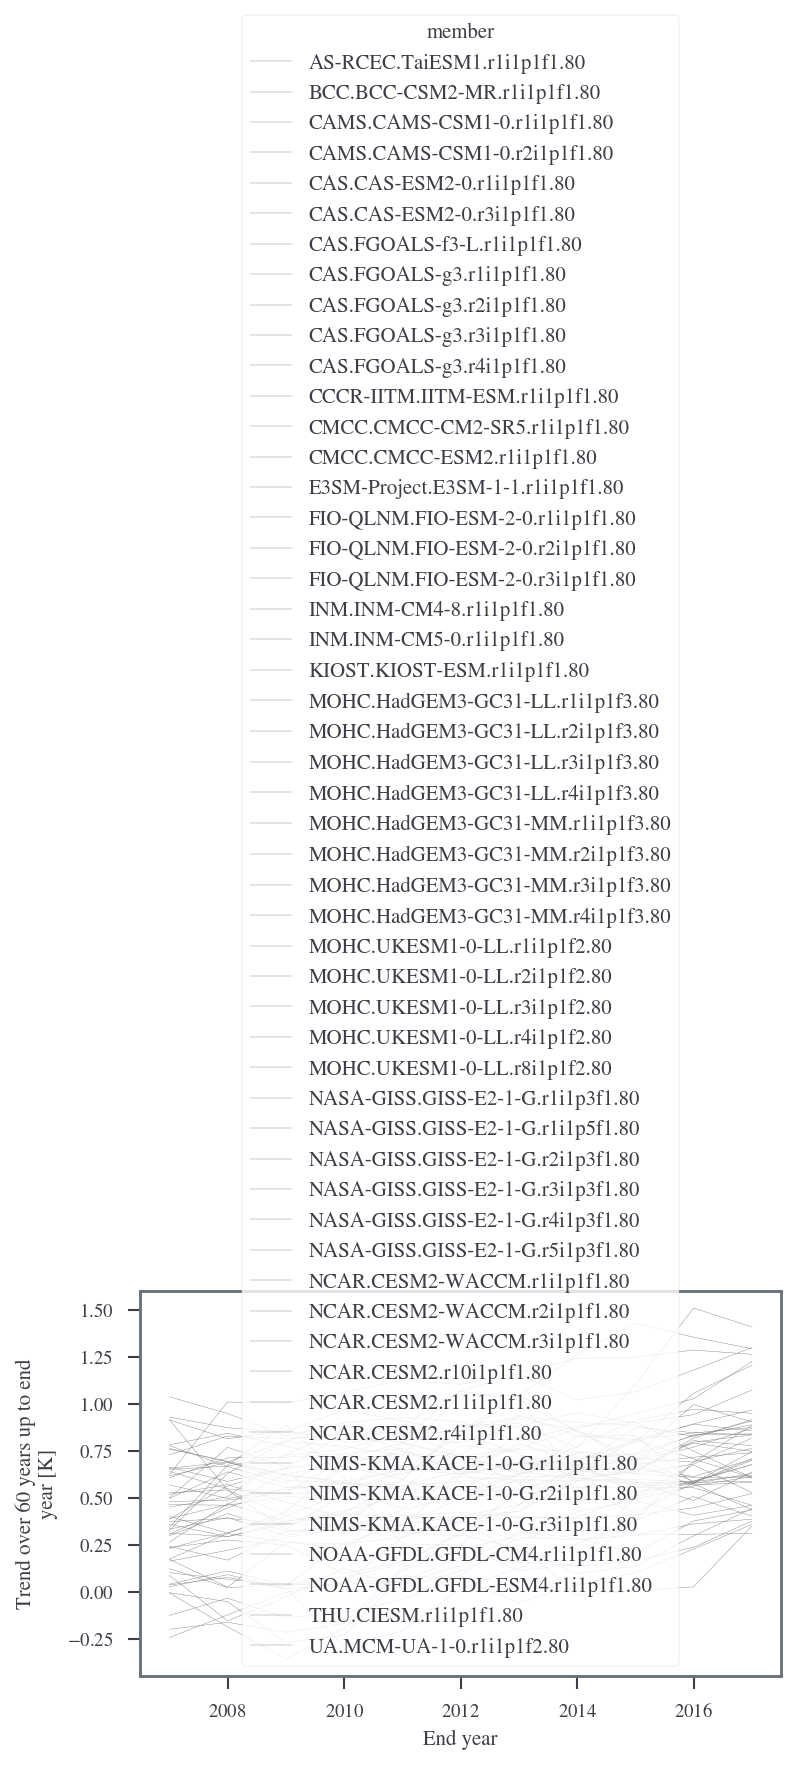

In [14]:
ts_nino34_ensemble_trend.rise.plot.line(hue="member", color="grey", linewidth=0.2)

In [ ]:
# da_tr_ensemble = get_trends(ts_ensemble)

In [28]:
ts_tr_mean = get_trends(ts_ensemble.mean("member"), beginning=2016, finish=2017).compute() - ts_trend_ecmwf

In [29]:
ts_tr_mean.rise.attrs["units"] = "$\Delta$K"
ts_tr_mean.rise.attrs["long_name"] = "$T_s$ Trend bias"

In [ ]:
ts_tr_mean.isel(end_year=1).rise.plot(cmap="cmo.balance", vmin=-2, vmax=2)

In [ ]:
rh_mmm = sel(
    can_coords(xr.open_mfdataset(cmip6_ensemble_var("hur") + "/*.nc")).hur, reg="pac"
).sel(T=slice("1958", "2017")).mean("T").mean("member").compute()

In [ ]:
sfcWind_mmm = sel(
    can_coords(xr.open_mfdataset(cmip6_ensemble_var("hur") + "/*.nc")).hur, reg="pac"
).sel(T=slice("1958", "2017"))

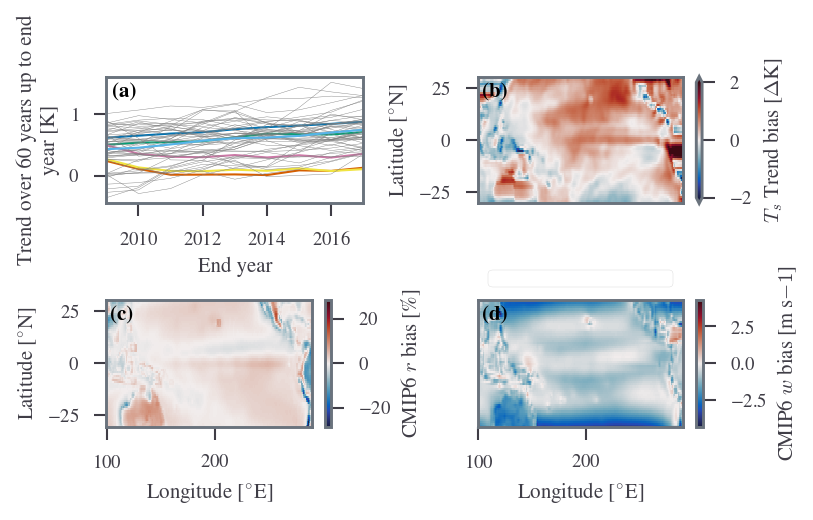

In [33]:
fig, axs = plt.subplots(2, 2)
da = xr.open_dataarray("temp.nc")
ts_trend_labels = da.plot.line(ax=axs[0, 0], hue="source")
ts_nino34_ensemble_trend.rise.plot.line(
    ax=axs[0, 0], hue="member", color="grey", linewidth=0.2
)
ts_nino34_mean_trend.rise.plot(ax=axs[0, 0])
axs[0, 0].set_xlim(2009, 2017)
ts_tr_mean.isel(end_year=1).rise.plot(ax=axs[0, 1], cmap="cmo.balance", vmin=-2, vmax=2)
axs[0, 1].set_title("")
axs[0, 1].set_xlabel("")
axs[0, 1].set_xticks([])
# da_tr_mean.isel(end_year=1).rise.plot(ax=axs[0,1], cmap="cmo.balance", vmin=-2, vmax=2)
add_units(bias_rh).plot(ax=axs[1, 0], cmap="cmo.balance")  # , vmin=0, vmax=100)
add_units(bias_wsp).plot(ax=axs[1, 1], cmap="cmo.balance")  # , vmin=0, vmax=100)
axs[1, 1].set_yticks([])
axs[1, 1].set_ylabel("")
axs[0, 0].get_legend().remove()
label_subplots(axs)
plt.legend(
    ts_trend_labels,
    bbox_to_anchor=(-0, 1.02, 1, 0.102),
    loc="lower left",
    mode="expand",
    ncol=2,
)
plt.tight_layout()

In [ ]:
rh_mmm

In [19]:
from src.constants import atmos_input_file_path

In [22]:
def get_pac(var="ts", model="E", ending="clim60"):
    return sel(
        can_coords(
            xr.open_dataarray(
                atmos_input_file_path(var=var, model=model, ending=ending)
            )
        ),
        reg="pac",
    )

In [25]:
bias_ts = get_pac(var="ts", model="S") - get_pac(var="ts", model="E")
bias_ts.attrs["units"] = "$\Delta$ K"
bias_ts.attrs["long_name"] = "CMIP6 $T_s$ bias"

In [26]:
bias_wsp = get_pac(var="sfcWind", model="S") - get_pac(var="sfcWind", model="E")
bias_wsp.attrs["units"] = "m s$-1$"
bias_wsp.attrs["long_name"] = "CMIP6 $w$ bias"

In [27]:
bias_rh = get_pac(var="rh", model="S") - get_pac(var="rh", model="E")
bias_rh.attrs["units"] = "%"
bias_rh.attrs["long_name"] = "CMIP6 $r$ bias"

In [ ]:
bias_rhC = get_pac(var="rh", model="C") - get_pac(var="rh", model="E")
bias_rhC.attrs["units"] = "%"
bias_rhC.attrs["long_name"] = "CMIP5 $r$ bias"
bias_rhC.plot()

In [ ]:
bias_rh.plot()

In [ ]:
bias_wsp.plot()

In [ ]:
bias_wspC = get_pac(var="sfcWind", model="C") - get_pac(var="sfcWind", model="E")
bias_wspC.attrs["units"] = "m s$-1$"
bias_wspC.attrs["long_name"] = "CMIP5 $w$ bias"
bias_wspC.plot()

In [ ]:
xr.open_dataarray(atmos_input_file_path(model="S"))

In [ ]:
ls /home/users/sithom/seager19/atmos/DATA/

In [24]:
ts_trend_ecmwf = get_pac(var="ts", model="E", ending="trend")